In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

class MLP:
    def __init__(self, hiddenSize, learningRate, max_loop, lambda_):
        # Initialization of the MLP model with given parameters
        self.hiddenNum = len(hiddenSize)
        self.hiddenSize = hiddenSize
        self.learningRate = learningRate
        self.max_loop = max_loop
        self.X = None
        self.Y = None
        self.w = None
        self.v = None
        self.hidw = None
        self.y_pred = None
        self.lambda_ = lambda_
    
    def sigmoid(self, z):
        # Sigmoid activation function
        return 1 / (1 + np.exp(-z))
    
    def tanh(self, x):
        # Hyperbolic tangent activation function
        return 2 * self.sigmoid(2 * x) - 1
    
    def ReLu(self, x):
        # Rectified Linear Unit (ReLU) activation function
        temp = x <= 0
        x[temp] = 0
        return x
    
    def leaky_relu(self, x):
        # Leaky ReLU activation function
        temp = x <= 0
        x[temp] *= 0.01
        return x
    
    def relu_derivative(self, y):
        # Derivative of ReLU activation function
        return np.where(y > 0, 1.0, 0.0)
    
    def leaky_relu_derivative(self, x):
        # Derivative of Leaky ReLU activation function
        return np.where(x > 0, 1.0, 0.01)
    
    def preprocess(self, X, Y):
        # Preprocessing of input data
        np.random.seed(1)
        X = np.insert(X, 0, 1, axis=1)
        self.X = X
        self.Y = Y
        # He initialization for the first hidden layer
        self.v = np.random.randn(self.hiddenSize[0], self.X.shape[1] - 1) * np.sqrt(2. / (self.X.shape[1] - 1))
        self.v = np.insert(self.v, 0, 0, axis=1)
        # Xavier initialization for the outer layer
        self.w = np.random.randn(self.Y.shape[1], self.hiddenSize[-1]) / np.sqrt(2. / (self.hiddenSize[-1] + self.Y.shape[1]))
        self.w = np.insert(self.w, 0, 0, axis=1)
        self.hidw = []
        # He initialization for subsequent hidden layers
        for i in range(1, self.hiddenNum):
            hw = np.random.randn(self.hiddenSize[i], self.hiddenSize[i - 1]) * np.sqrt(2. / (self.hiddenSize[i - 1]))
            hw = np.insert(hw, 0, 0, axis=1)
            self.hidw.append(hw)
            
    def forward(self):
        # Forward propagation through the MLP
        self.h = []
        for i in range(self.hiddenNum):
            if i == 0:
                h = self.ReLu(np.dot(self.X, self.v.T))
                self.h.append(h)
            else:
                h = self.ReLu(np.dot(np.insert(self.h[i - 1], 0, 1, axis=1), self.hidw[i - 1].T))
                self.h.append(h)
        self.y_pred = self.sigmoid(np.dot(np.insert(self.h[-1], 0, 1, axis=1), self.w.T))
        
    def loss(self):
        # Calculate the loss function
        y_pred = np.where(self.y_pred > 0.5, 1, 0)
        err = self.y_pred - self.Y
        total_err = np.sum(np.square(err)) / 2  # Total Mean Squared Error (MSE)
        l2_regularization = (self.lambda_ / 2) * (
            np.sum(np.square(self.v)) + np.sum(np.square(self.w)) + sum([np.sum(np.square(hw)) for hw in self.hidw])
        )
        total_err += l2_regularization
        return total_err
    
    def gradient(self):
        # Compute the gradients for backpropagation
        err = self.y_pred - self.Y
        grad_out = err
        grad_z = self.y_pred * (1 - self.y_pred)
        self.grad_w = np.dot(np.insert(self.h[-1], 0, 1, axis=1).T, grad_out * grad_z).T
        self.grad_hidw = []
        if self.hiddenNum == 1:
            grad_h = np.dot(grad_out * grad_z, self.w[:, 1:])
            grad_z = self.relu_derivative(self.h[0])
            self.grad_v = np.dot(self.X.T, grad_h * grad_z).T
        else:
            for i in range(self.hiddenNum - 1, 0, -1):
                if i == self.hiddenNum - 1:
                    grad_h = np.dot(grad_out * grad_z, self.w[:, 1:])
                else:
                    grad_h = np.dot(grad_h_0, self.hidw[i][:, 1:])
                grad_z = self.relu_derivative(self.h[i])
                grad_hidw = np.dot(np.insert(self.h[i - 1], 0, 1, axis=1).T, grad_h * grad_z).T
                self.grad_hidw.append(grad_hidw)
                grad_h_0 = grad_h
            grad_h = np.dot(grad_h_0, self.hidw[0][:, 1:])
            grad_z = self.relu_derivative(self.h[0])
            self.grad_v = np.dot(self.X.T, grad_h * grad_z).T
        # L2 regularization
        self.grad_w += self.lambda_ * self.w
        self.grad_v += self.lambda_ * self.v
        for i in range(len(self.hidw)):
            self.grad_hidw[i] += self.lambda_ * self.hidw[-1 - i]
            
    def train(self):
        # Training the MLP using gradient descent
        mse_values = []  # List to store MSE values for each iteration
        for _ in range(self.max_loop + 1):
            self.forward()
            self.gradient()
            self.w = self.w - self.learningRate * self.grad_w
            for i in range(len(self.hidw)):
                self.hidw[i] = self.hidw[i] - self.learningRate * self.grad_hidw[-1 - i]
            self.v = self.v - self.learningRate * self.grad_v
            if _ % 100 == 0:
                print("Epoch: ", _, " MSE: ", self.loss())
                mse = self.loss()
                mse_values.append(mse)
        plt.plot(range(0, self.max_loop + 1, 100), mse_values)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        title = 'Epoch-MSE Graph, learning rate = ' + str(self.learningRate) + r', $\alpha$=' + str(self.lambda_)
        plt.title(title)
        plt.grid(True)
        plt.show()
        
    def predict(self, X):
        # Make predictions using the trained model
        X = np.insert(X, 0, 1, axis=1)
        h = []
        for i in range(self.hiddenNum):
            if i == 0:
                h.append(self.ReLu(np.dot(X, self.v.T)))
            else:
                h.append(self.ReLu(np.dot(np.insert(h[i - 1], 0, 1, axis=1), self.hidw[i - 1].T)))
        y_pred = self.sigmoid(np.dot(np.insert(h[-1], 0, 1, axis=1), self.w.T))
        return np.round(y_pred)
        
    def plot_boundary(self):
        # Plot the decision boundary
        x_min, x_max = self.X[:, 1].min() - 0.1, self.X[:, 1].max() + 0.1
        y_min, y_max = self.X[:, 2].min() - 0.1, self.X[:, 2].max() + 0.1
        h = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.scatter(self.X[:, 1], self.X[:, 2], c=self.Y[:, 0], cmap=plt.cm.Spectral)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        title = 'Decision Boundary, learning rate = ' + str(self.learningRate) + r', $\alpha$=' + str(self.lambda_)
        plt.title(title)
        plt.show()
    
    def score(self, X, Y):
        # Evaluate the model using metrics
        y_pred = self.predict(X)
        conf_matrix = confusion_matrix(Y, y_pred)
        print("Confusion Matrix:")
        print(conf_matrix)
        precision = precision_score(Y, y_pred)
        print("Precision:", precision)
        recall = recall_score(Y, y_pred)
        print("Recall:", recall)
        f1 = f1_score(Y, y_pred)
        print("F1 Score:", f1)

# Dataset
one_points = np.array([[-2.2, 1.8], [-4, 0], [4, -4], [3.5, -2], [3, -3], [0.5, 0], [1, 0], [3, 4], [4, 5], [1, 2], [2, 3], [1, -1], [0.5, -3], [-4, 4.5], [-4.5, 4]])
zero_points = np.array([[1.8, -2.7], [2, -3], [1.7, 1.7], [-2, -3], [-1, -1], [-2, 3], [-1, 2], [-4, -4], [-4.5, -4], [-3, -4], [-4, -3], [-3, -3], [-3, -2], [-2, -2], [1, 1]])
input_data = np.vstack((one_points, zero_points))
output_data = np.vstack((np.ones((one_points.shape[0], 1)), np.zeros((zero_points.shape[0], 1)))).reshape(30, 1)



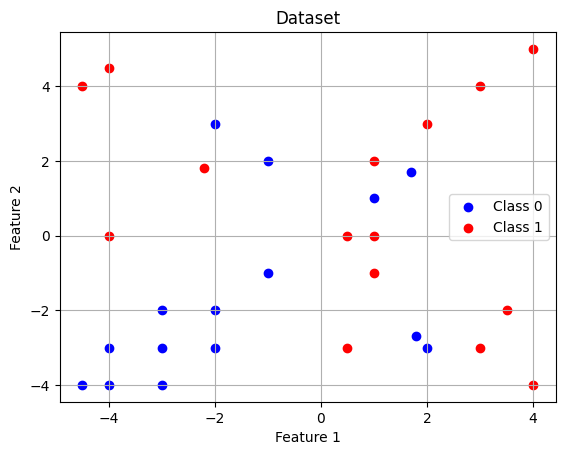

In [2]:
# Separate data with labels 0 and 1 into different variables
class_0 = input_data[output_data.flatten() == 0]
class_1 = input_data[output_data.flatten() == 1]

# Plot scatter plot
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', label='Class 1')

# Add legend
plt.legend()

# Add axis labels
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset')
plt.grid(True)
# Display the plot
plt.show()


Epoch:  0  MSE:  5.1961274265173065
Epoch:  100  MSE:  3.2751329339924715
Epoch:  200  MSE:  3.272930256871081
Epoch:  300  MSE:  3.2710852543563957
Epoch:  400  MSE:  3.269314793727497
Epoch:  500  MSE:  3.2675687865857896
Epoch:  600  MSE:  3.2658292436096685
Epoch:  700  MSE:  3.264085596834172
Epoch:  800  MSE:  3.262328375971094
Epoch:  900  MSE:  3.2605461621201304
Epoch:  1000  MSE:  3.258722509321558
Epoch:  1100  MSE:  3.256830753877843
Epoch:  1200  MSE:  3.2548227905356697
Epoch:  1300  MSE:  3.2526000825552024
Epoch:  1400  MSE:  3.249920844351034
Epoch:  1500  MSE:  3.245982130661243
Epoch:  1600  MSE:  3.2355113087237273
Epoch:  1700  MSE:  2.7753659572232277
Epoch:  1800  MSE:  2.2912749722112324
Epoch:  1900  MSE:  2.277756634211072
Epoch:  2000  MSE:  2.2666795107022195
Epoch:  2100  MSE:  1.522739525791271
Epoch:  2200  MSE:  1.34775477490372
Epoch:  2300  MSE:  1.3222984562708953
Epoch:  2400  MSE:  1.3108698466591897
Epoch:  2500  MSE:  1.303673191490749
Epoch:  260

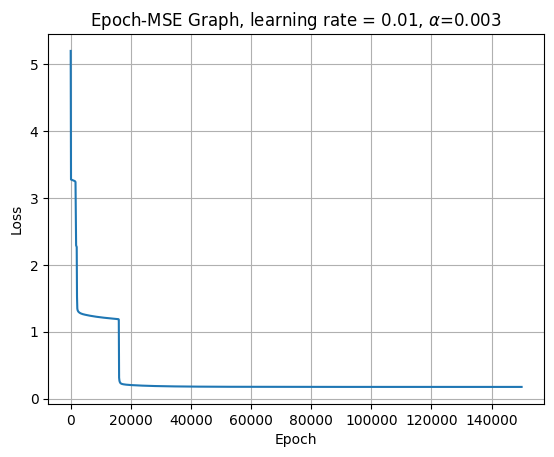

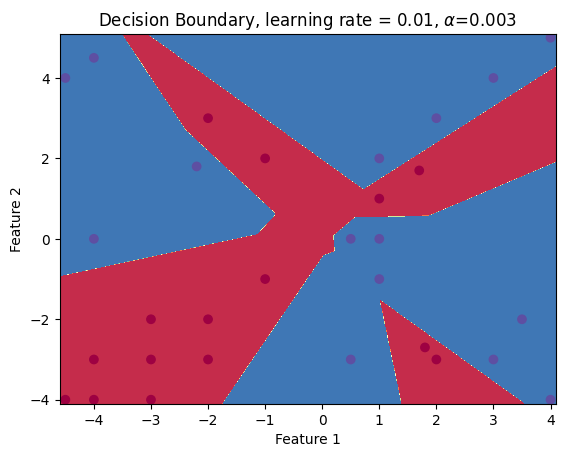

Confusion Matrix:
[[15  0]
 [ 0 15]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [3]:
# Construct the MLP model, hidden layer size = 20, learning rate = 0.01, max_loop = 150000, lambda = 0.003
model0=MLP([20],0.01,150000,0.003)
model0.preprocess(input_data,output_data)
model0.train()
model0.plot_boundary()
model0.score(input_data,output_data)

Epoch:  0  MSE:  6.77248181869688
Epoch:  100  MSE:  4.046406910938784
Epoch:  200  MSE:  3.923606370490015
Epoch:  300  MSE:  3.9153178398523694
Epoch:  400  MSE:  3.9171349138276046
Epoch:  500  MSE:  3.8735438297895746
Epoch:  600  MSE:  3.830482517356008
Epoch:  700  MSE:  3.7819286818079187
Epoch:  800  MSE:  3.7420149380699925
Epoch:  900  MSE:  3.6988822083638193
Epoch:  1000  MSE:  3.6529346290172477
Epoch:  1100  MSE:  3.6150930508193486
Epoch:  1200  MSE:  3.5832529651406135
Epoch:  1300  MSE:  3.5552881083147825
Epoch:  1400  MSE:  3.5292265785662376
Epoch:  1500  MSE:  3.501393842117826
Epoch:  1600  MSE:  1.8784424649193738
Epoch:  1700  MSE:  1.7397765757100236
Epoch:  1800  MSE:  1.6881524363208056
Epoch:  1900  MSE:  1.8322118896800654
Epoch:  2000  MSE:  1.6367853551668157
Epoch:  2100  MSE:  1.3986543301500396
Epoch:  2200  MSE:  1.241818045426637
Epoch:  2300  MSE:  1.0622027835978658
Epoch:  2400  MSE:  0.9216911690281322
Epoch:  2500  MSE:  0.8260128341485085
Epoch

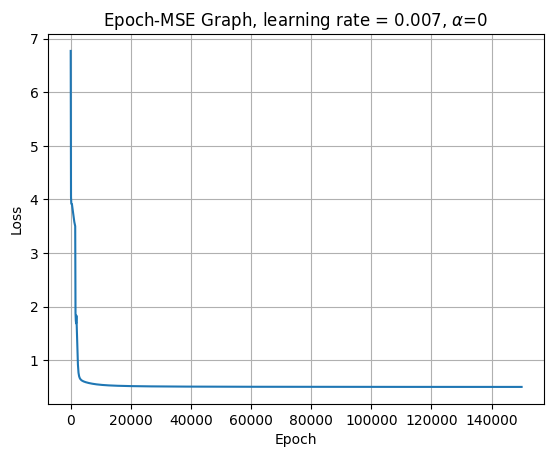

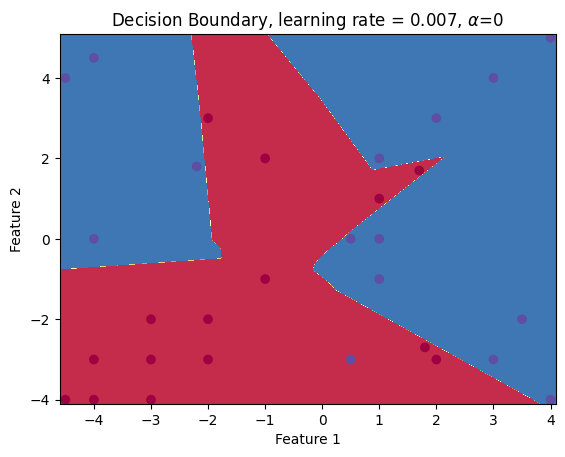

Confusion Matrix:
[[15  0]
 [ 1 14]]
Precision: 1.0
Recall: 0.9333333333333333
F1 Score: 0.9655172413793104


In [4]:
# Construct the MLP model, hidden layer size = [5,4], learning rate = 0.007, max_loop = 150000, lambda = 0
model1=MLP([5,4],0.007,150000,0)
model1.preprocess(input_data,output_data)
model1.train()
model1.plot_boundary()
model1.score(input_data,output_data)

Epoch:  0  MSE:  4.47568514231207
Epoch:  100  MSE:  2.0722928414917603
Epoch:  200  MSE:  2.0372326195797377
Epoch:  300  MSE:  2.028753661272503
Epoch:  400  MSE:  2.024294850486304
Epoch:  500  MSE:  2.019275883903035
Epoch:  600  MSE:  2.014975862800955
Epoch:  700  MSE:  2.011371998890678
Epoch:  800  MSE:  2.008578656764843
Epoch:  900  MSE:  2.0047399139788307
Epoch:  1000  MSE:  1.999889991193158
Epoch:  1100  MSE:  1.9937791379374503
Epoch:  1200  MSE:  1.9834708004356532
Epoch:  1300  MSE:  1.9647517476623713
Epoch:  1400  MSE:  1.7557124809335918
Epoch:  1500  MSE:  1.443408970565237
Epoch:  1600  MSE:  1.4598970365405672
Epoch:  1700  MSE:  1.4584845880868786
Epoch:  1800  MSE:  1.4843471669872619
Epoch:  1900  MSE:  1.4801687046773033
Epoch:  2000  MSE:  1.4763768942488746
Epoch:  2100  MSE:  1.4883464471030394
Epoch:  2200  MSE:  1.4870468157194863
Epoch:  2300  MSE:  1.8979634217600678
Epoch:  2400  MSE:  1.8983855266694338
Epoch:  2500  MSE:  1.9212116833220585
Epoch:  

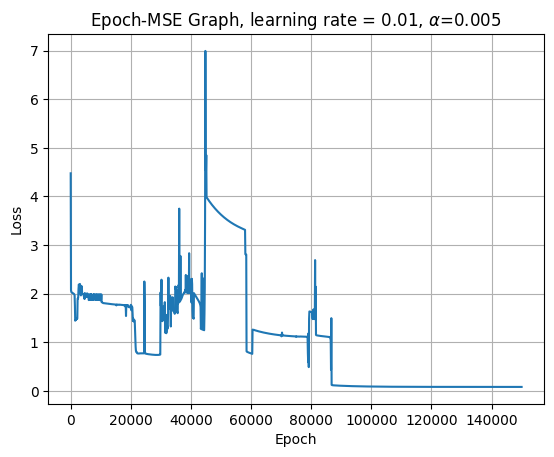

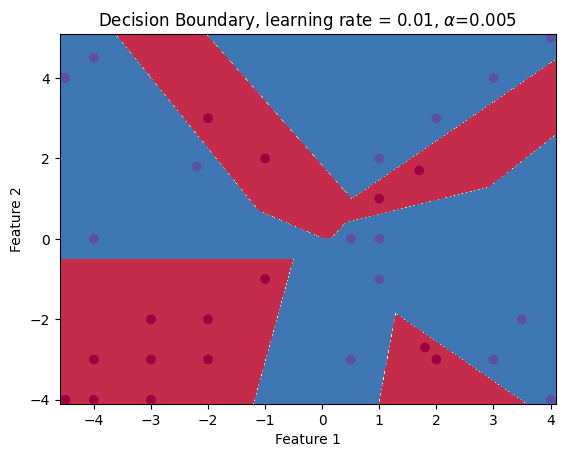

Confusion Matrix:
[[15  0]
 [ 0 15]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [5]:
# Construct the MLP model, hidden layer size = [6,5,5,5], learning rate = 0.01, max_loop = 150000, lambda = 0.005
model2=MLP([6,5,5,5],0.01,150000,0.005)
model2.preprocess(input_data,output_data)
model2.train()
model2.plot_boundary()
model2.score(input_data,output_data)

Epoch:  0  MSE:  2.6724400557523573
Epoch:  100  MSE:  2.3067068023204604
Epoch:  200  MSE:  2.090048566393931
Epoch:  300  MSE:  1.927216671853431
Epoch:  400  MSE:  1.8040774209525936
Epoch:  500  MSE:  1.73757840704314
Epoch:  600  MSE:  1.7051246585459152
Epoch:  700  MSE:  1.6833360538944167
Epoch:  800  MSE:  1.6678503654927597
Epoch:  900  MSE:  1.6564773908686694
Epoch:  1000  MSE:  1.6479083206178489
Epoch:  1100  MSE:  1.641229256917911
Epoch:  1200  MSE:  1.635978149713787
Epoch:  1300  MSE:  1.6317430717140027
Epoch:  1400  MSE:  1.6282941189137259
Epoch:  1500  MSE:  1.6254339139751264
Epoch:  1600  MSE:  1.623032547110756
Epoch:  1700  MSE:  1.62099411415458
Epoch:  1800  MSE:  1.6192499959678814
Epoch:  1900  MSE:  1.6177511121419506
Epoch:  2000  MSE:  1.6164376478037534
Epoch:  2100  MSE:  1.6152850926179365
Epoch:  2200  MSE:  1.6142724543277072
Epoch:  2300  MSE:  1.6133714707114641
Epoch:  2400  MSE:  1.6125658185323328
Epoch:  2500  MSE:  1.6118419899008145
Epoch: 

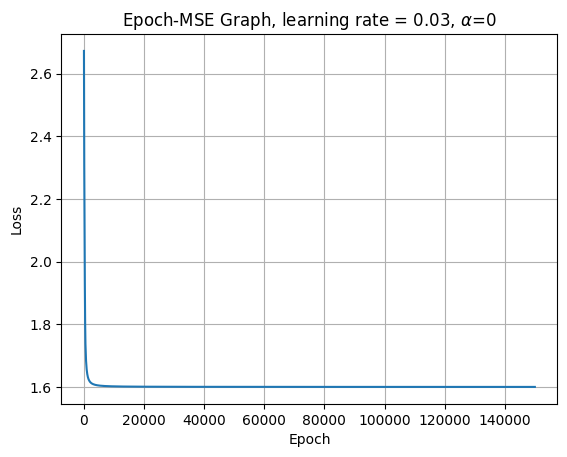

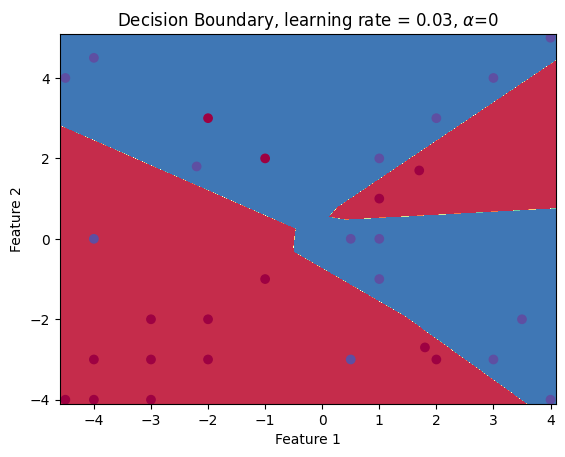

Confusion Matrix:
[[13  2]
 [ 2 13]]
Precision: 0.8666666666666667
Recall: 0.8666666666666667
F1 Score: 0.8666666666666667


In [6]:
# Construct the MLP model, hidden layer size = [5], learning rate = 0.03, max_loop = 150000, lambda = 0
model3=MLP([5],0.03,150000,0)
model3.preprocess(input_data,output_data)
model3.train()
model3.plot_boundary()
model3.score(input_data,output_data)

Epoch:  0  MSE:  8.95443712507729
Epoch:  100  MSE:  7.103992290851226
Epoch:  200  MSE:  6.78677592367835
Epoch:  300  MSE:  6.456875377092672
Epoch:  400  MSE:  6.327054695863829
Epoch:  500  MSE:  0.9707019552349169
Epoch:  600  MSE:  0.8723622897017311
Epoch:  700  MSE:  0.8131199928721807
Epoch:  800  MSE:  0.7660727890553228
Epoch:  900  MSE:  0.7175731387947021
Epoch:  1000  MSE:  0.6576510391848517
Epoch:  1100  MSE:  0.559928295943894
Epoch:  1200  MSE:  0.4726202107474352
Epoch:  1300  MSE:  0.4051786406014845
Epoch:  1400  MSE:  0.342882589138942
Epoch:  1500  MSE:  0.2963183642504589
Epoch:  1600  MSE:  0.255881934238744
Epoch:  1700  MSE:  0.22870746500002231
Epoch:  1800  MSE:  0.20870685704172837
Epoch:  1900  MSE:  0.18844987030217195
Epoch:  2000  MSE:  0.1710967552365172
Epoch:  2100  MSE:  0.15762915839555644
Epoch:  2200  MSE:  0.1457656691055869
Epoch:  2300  MSE:  0.13485962189457565
Epoch:  2400  MSE:  0.12431973040618555
Epoch:  2500  MSE:  0.11582738105847537
E

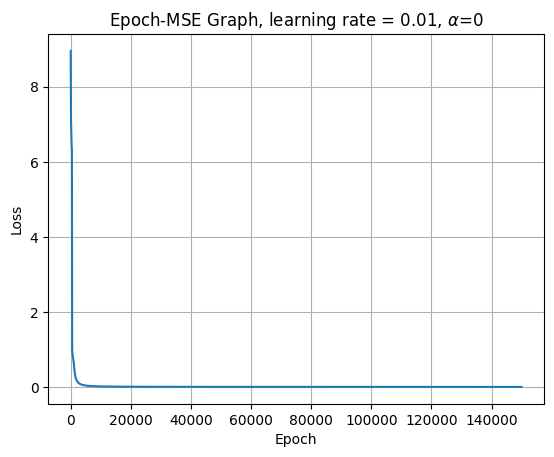

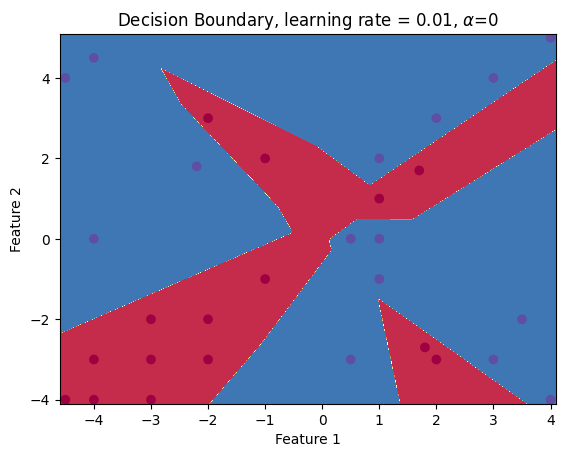

Confusion Matrix:
[[15  0]
 [ 0 15]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [7]:
# Construct the MLP model, hidden layer size = [10], learning rate = 0.01, max_loop = 150000, lambda = 0
model4=MLP([10],0.01,150000,0)
model4.preprocess(input_data,output_data)
model4.train()
model4.plot_boundary()
model4.score(input_data,output_data)

Generate a complex dataset

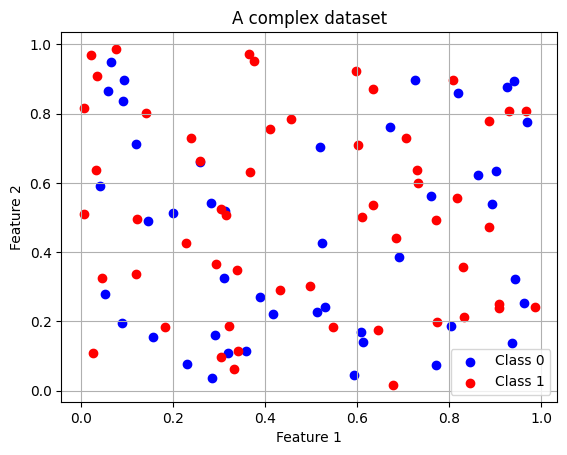

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)

# Generate n data points
n = 100

# Generate input data with two features
X = np.random.rand(n, 2)

# Generate corresponding binary labels (0 or 1)
y = np.random.randint(2, size=(n, 1))

# Separate data with labels 0 and 1 into different variables
class_0 = X[y.flatten() == 0]
class_1 = X[y.flatten() == 1]

# Plot scatter plot
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', label='Class 1')

# Add legend
plt.legend()

# Add axis labels
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('A complex dataset')
plt.grid(True)
# Display the plot
plt.show()


Epoch:  0  MSE:  22.21041474561402
Epoch:  100  MSE:  16.618707017634478
Epoch:  200  MSE:  16.055382401901127
Epoch:  300  MSE:  14.315471687191076
Epoch:  400  MSE:  13.06771624411316
Epoch:  500  MSE:  12.138260976782467
Epoch:  600  MSE:  13.022907269803824
Epoch:  700  MSE:  13.276750343744057
Epoch:  800  MSE:  12.537042056267081
Epoch:  900  MSE:  12.19151609660105
Epoch:  1000  MSE:  11.97723829361351
Epoch:  1100  MSE:  11.710762089628322
Epoch:  1200  MSE:  11.507144659702353
Epoch:  1300  MSE:  11.301305112617754
Epoch:  1400  MSE:  11.217193156717116
Epoch:  1500  MSE:  10.95882629310197
Epoch:  1600  MSE:  10.920675665628227
Epoch:  1700  MSE:  10.78810801400952
Epoch:  1800  MSE:  10.738104472892049
Epoch:  1900  MSE:  10.606223193091461
Epoch:  2000  MSE:  10.445919318048508
Epoch:  2100  MSE:  10.31140896141505
Epoch:  2200  MSE:  10.19910420464329
Epoch:  2300  MSE:  10.157880093272444
Epoch:  2400  MSE:  10.165831176994137
Epoch:  2500  MSE:  10.088673185462108
Epoch:

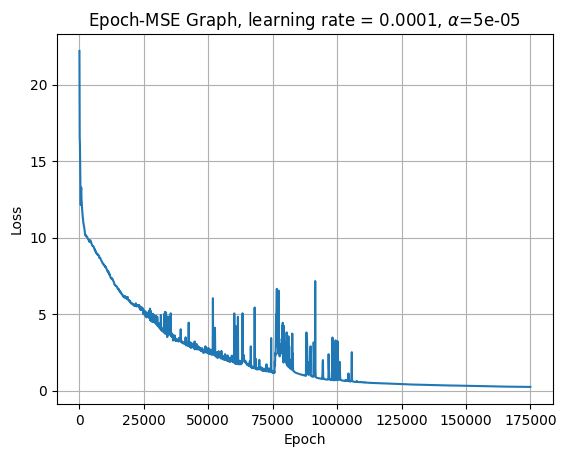

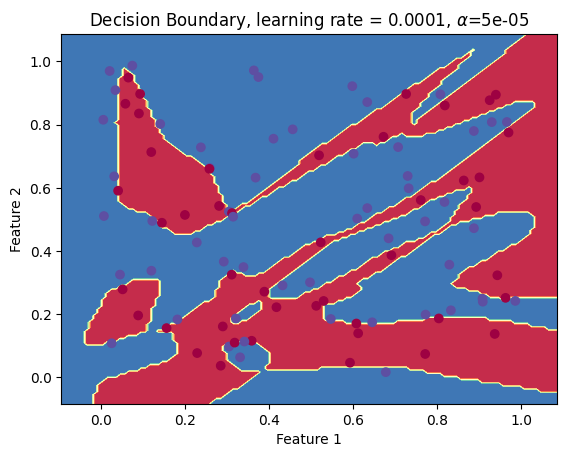

Confusion Matrix:
[[45  0]
 [ 0 55]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [9]:
# Construct the MLP model, hidden layer size = [50,50,50,50], learning rate = 0.0001, max_loop = 175000, lambda = 0.00005
model5=MLP([50,50,50,50],0.0001,175000,0.00005)
model5.preprocess(X,y)
model5.train()
model5.plot_boundary()
model5.score(X,y)

Epoch:  0  MSE:  27.4876633221274
Epoch:  100  MSE:  26.219793396045535
Epoch:  200  MSE:  26.178547602350054
Epoch:  300  MSE:  26.145210655446352
Epoch:  400  MSE:  26.12743273210469
Epoch:  500  MSE:  26.107215474023732
Epoch:  600  MSE:  26.084423835839257
Epoch:  700  MSE:  26.054095453468758
Epoch:  800  MSE:  26.00540057080185
Epoch:  900  MSE:  25.856769356079976
Epoch:  1000  MSE:  25.59408985702343
Epoch:  1100  MSE:  25.483082737854343
Epoch:  1200  MSE:  25.420247199700125
Epoch:  1300  MSE:  25.363700473223226
Epoch:  1400  MSE:  25.311749357791037
Epoch:  1500  MSE:  25.263518651715216
Epoch:  1600  MSE:  25.19480731746441
Epoch:  1700  MSE:  25.111169052550878
Epoch:  1800  MSE:  25.00987827143544
Epoch:  1900  MSE:  24.91608827261195
Epoch:  2000  MSE:  24.817759847493083
Epoch:  2100  MSE:  24.683825826113647
Epoch:  2200  MSE:  24.530118195626283
Epoch:  2300  MSE:  24.32570738968366
Epoch:  2400  MSE:  24.034927065179463
Epoch:  2500  MSE:  23.19595279559635
Epoch:  

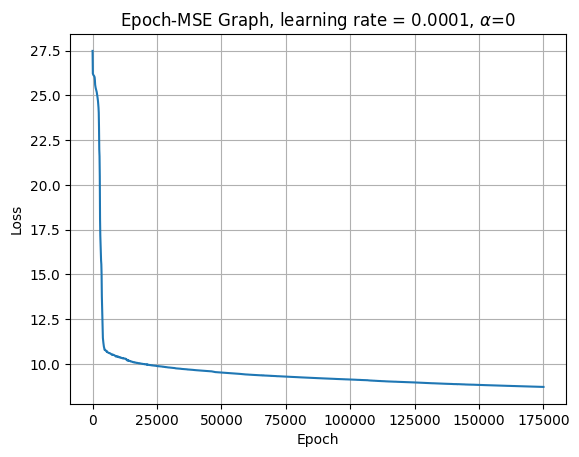

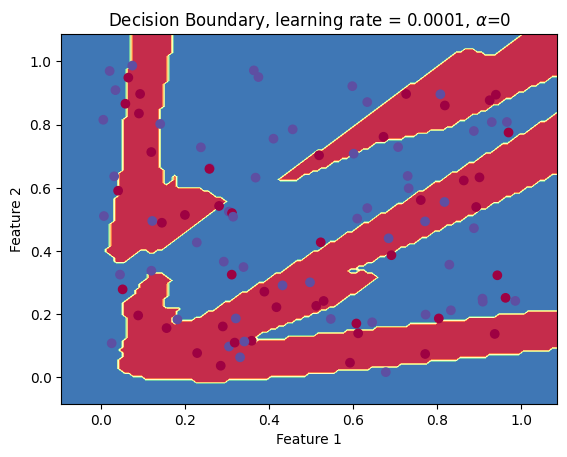

Confusion Matrix:
[[33 12]
 [12 43]]
Precision: 0.7818181818181819
Recall: 0.7818181818181819
F1 Score: 0.7818181818181819


In [10]:
# Construct the MLP model, hidden layer size = [100], learning rate = 0.0001, max_loop = 175000, lambda = 0
model6=MLP([100],0.0001,175000,0)
model6.preprocess(X,y)
model6.train()
model6.plot_boundary()
model6.score(X,y)